# Importing Packages and Basic Parameters

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
import os
import scipy.io as sio
import pickle
import matplotlib.pyplot as plt
import keras
# import random as rn

from scipy import stats
from os import listdir
from tensorflow.python.client import device_lib
from keras.models import Sequential, load_model
from keras.layers import Add, GRU,CuDNNGRU, Bidirectional, LeakyReLU, Dense, Dropout, Input, Convolution1D, Layer, Concatenate, BatchNormalization, Reshape, Flatten, Activation
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping
from keras.models import Model
from keras import regularizers, initializers, constraints
from keras import backend as K
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from keras.losses import categorical_crossentropy, mean_squared_error
from keras.utils import plot_model
from tqdm import tqdm
from rdkit import Chem
random_seed = 34
batch_size = 64*32
num_classes = 1
epochs = 30

Using TensorFlow backend.


In [6]:
train_raw = pd.read_csv('train_sequences.txt', delimiter = '\t', header=None)
train_raw.head()

,0,1
0,TGCATTTTTTTCACATCTCTTTGCCACGGGGTGAAGGATAGGATGG...,11.0
1,TGCATTTTTTTCACATCTATGTTGCGTTAGAACGATATTGGAACAC...,6.0
2,TGCATTTTTTTCACATCTGTGAAGAATATCAGCTTTCAATCGTATT...,8.0
3,TGCATTTTTTTCACATCAATCCGAGATATCTGTTGATAAACTTACC...,9.0
4,TGCATTTTTTTCACATCAAGTTATCTGGTGTACGTTTTCTCGTATA...,12.0


In [7]:
train_raw.tail()

,0,1
6739253,TGCATTTTTTTCACATCCCGATTCAGCAAAATTGGTGGTTATTCTC...,11.000000
6739254,TGCATTTTTTTCACATCGTCGGCGCGAGGTACGGGAGGGCCCGACA...,14.000000
6739255,TGCATTTTTTTCACATCACGGAGTGGATGCTTGAAATCAAGAACAC...,5.223988
6739256,TGCATTTTTTTCACATCAGTCCGCCGAGCAAAGGTTTGTTATTTAT...,12.000000
6739257,TGCATTTTTTTCACATCTTCTTTTTTATTATATGTGTGATGCGCTC...,10.463105


In [8]:
train_raw[1].max(), train_raw[1].min()

(17.0, 0.0)

In [9]:
train_raw[1].median()

11.0

In [10]:
len(train_raw[0])

6739258

In [12]:
test_raw = pd.read_csv('test_sequences.txt', delimiter = '\t', header=None)
test_raw.head()

,0,1
0,TGCATTTTTTTCACATCAAAAAAAAAAAAAAAAAAAAAAACTAGCA...,NaN
1,TGCATTTTTTTCACATCAAAAAAAAAAAAAAAAAAAGAAAACGAGC...,NaN
2,TGCATTTTTTTCACATCAAAAAAAAAAAAAAAAAAAGAAAACGAGC...,NaN
3,TGCATTTTTTTCACATCAAAAAAAAAAAAAAAAAAAGAAAACGAGC...,NaN
4,TGCATTTTTTTCACATCAAAAAAAAAAAAAAAAAAAGAAAACGAGC...,NaN


In [13]:
test_raw.tail()

,0,1
71098,TGCATTTTTTTCACATCTTTTTTTTCTTCGTACATAGTGACGGGAC...,NaN
71099,TGCATTTTTTTCACATCTTTTTTTTCTTCGTACATAGTGACGGGAC...,NaN
71100,TGCATTTTTTTCACATCTTTTTTTTCTTCGTACATAGTGACGGGAC...,NaN
71101,TGCATTTTTTTCACATCTTTTTTTTCTTCGTACATAGTGACGGGAC...,NaN
71102,TGCATTTTTTTCACATCTTTTTTTTCTTCGTACATAGTGACGGGAC...,NaN


# Data Combining

In [ ]:
AGCTNTable = {'T':[1,0,0,0], 'C':[0,1,0,0], 'G':[0,0,1,0], 'A':[0,0,0,1],'N':[1,1,1,1]}
AGCTNTable_c = {'A':[1,0,0,0], 'G':[0,1,0,0], 'C':[0,0,1,0], 'T':[0,0,0,1],'N':[1,1,1,1]}
maxLength = 142
train_all = np.zeros((len(train_raw[0]),maxLength,4), dtype='uint8')
train_all_c = np.zeros((len(train_raw[0]),maxLength,4), dtype='uint8')
for i in tqdm(range(len(train_raw[0]))):
    tempLength = len(train_raw[0][i])
    for j in range(tempLength):
        train_all[i,maxLength-tempLength+j,:] = AGCTNTable[train_raw[0][i][j]]
        train_all_c[i,maxLength-tempLength+j,:] = AGCTNTable_c[train_raw[0][i][-j-1]]
train_all.shape, train_all_c.shape

In [ ]:
np.save('train_allX',train_all)
np.save('train_allX_c',train_all_c)
np.save('train_allY',train_raw[1].values)

In [ ]:
AGCTNTable = {'T':[1,0,0,0], 'C':[0,1,0,0], 'G':[0,0,1,0], 'A':[0,0,0,1],'N':[1,1,1,1]}
AGCTNTable_c = {'A':[1,0,0,0], 'G':[0,1,0,0], 'C':[0,0,1,0], 'T':[0,0,0,1],'N':[1,1,1,1]}
maxLength = 142
test_all = np.zeros((len(test_raw[0]),maxLength,4), dtype='uint8')
test_all_c = np.zeros((len(test_raw[0]),maxLength,4), dtype='uint8')
for i in tqdm(range(len(test_raw[0]))):
    tempLength = len(test_raw[0][i])
    for j in range(tempLength):
        test_all[i,maxLength-tempLength+j,:] = AGCTNTable[test_raw[0][i][j]]
        test_all_c[i,maxLength-tempLength+j,:] = AGCTNTable[test_raw[0][i][-j-1]]
test_all.shape, test_all_c.shape

In [ ]:
np.save('test_allX',test_all)
np.save('test_allX_c',test_all_c)

# Data Preprocessing

In [29]:
X_list = np.load('train_allX.npy')
# X_list_c = np.load('./gdrive/MyDrive/ColabDrive/train_allX_c.npy')
Y_list = np.load('train_allY.npy')
X_list.shape, Y_list.shape

((6739258, 142, 4), (6739258,))

In [30]:
medianY = np.median(Y_list)
Y_list = Y_list/(2*medianY)
np.max(Y_list)

0.7727272727272727

# CPU and GPU Checking

In [31]:
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))
print(device_lib.list_local_devices())

Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device
/job:localhost/replica:0/task:0/device:XLA_GPU:0 -> device: XLA_GPU device
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 12227944869408220547
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 7984620458453171024
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 286826605362200211
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 15964005991
locality {
  bus_id: 1
  links {
  }
}
incarnation: 6041425920576494438
physical_device_desc: "device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capabil

# Defining Evaluating Function

In [16]:
def coeff_determination(y_true, y_pred):
  SS_res =  K.sum(K.square( y_true-y_pred )) 
  SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) ) 
  return ( 1 - SS_res/(SS_tot + K.epsilon()) )

def coeff_determination_loss(y_true, y_pred):
  SS_res =  K.sum(K.square( y_true-y_pred )) 
  SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) ) 
  return -( 1 - SS_res/(SS_tot + K.epsilon()) )


# Defining Attention Layer

In [17]:
def dot_product(x, kernel):
    if K.backend() == 'tensorflow':
        return K.squeeze(K.dot(x, K.expand_dims(kernel)), axis=-1)
    else:
        return K.dot(x, kernel)
    
class AttentionWithContext(Layer):
    def __init__(self,
                 W_regularizer=None, u_regularizer=None, b_regularizer=None,
                 W_constraint=None, u_constraint=None, b_constraint=None,
                 bias=True, **kwargs): 
        self.supports_masking = True
        self.init = initializers.get('glorot_uniform') 
        self.W_regularizer = regularizers.get(W_regularizer)
        self.u_regularizer = regularizers.get(u_regularizer)
        self.b_regularizer = regularizers.get(b_regularizer) 
        self.W_constraint = constraints.get(W_constraint)
        self.u_constraint = constraints.get(u_constraint)
        self.b_constraint = constraints.get(b_constraint) 
        self.bias = bias
        super(AttentionWithContext, self).__init__(**kwargs)
 
    def build(self, input_shape):
        assert len(input_shape) == 3
        self.W = self.add_weight(shape=(input_shape[-1], input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_W'.format(self.name),
                                 regularizer=self.W_regularizer,
                                 constraint=self.W_constraint)
        if self.bias:
            self.b = self.add_weight(shape=(input_shape[-1],),
                                     initializer='zero',
                                     name='{}_b'.format(self.name),
                                     regularizer=self.b_regularizer,
                                     constraint=self.b_constraint) 
            self.u = self.add_weight(shape=(input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_u'.format(self.name),
                                 regularizer=self.u_regularizer,
                                 constraint=self.u_constraint) 
        super(AttentionWithContext, self).build(input_shape)
 
    def compute_mask(self, input, input_mask=None):
        return None
 
    def call(self, x, mask=None):
        uit = dot_product(x, self.W) 
        if self.bias:
            uit += self.b 
        uit = K.tanh(uit)
        ait = dot_product(uit, self.u) 
        a = K.exp(ait)
        if mask is not None:
            a *= K.cast(mask, K.floatx())
        a /= K.cast(K.sum(a, axis=1, keepdims=True) + K.epsilon(), K.floatx()) 
        a = K.expand_dims(a)
        weighted_input = x * a
        return K.sum(weighted_input, axis=1)
 
    def compute_output_shape(self, input_shape):
        return input_shape[0], input_shape[-1]

# Model structure

In [18]:
#model structure
def MetforNet121(length):
    # outputAttentions = []
    main_input = Input(shape=(length,4), dtype='float32', name='main_input')
    x = Bidirectional(CuDNNGRU(64,return_sequences=True,return_state=False))(main_input)
    x = Bidirectional(CuDNNGRU(64,return_sequences=True,return_state=False))(x)
    x = Bidirectional(CuDNNGRU(64,return_sequences=True,return_state=False))(x)
    x = Bidirectional(CuDNNGRU(64,return_sequences=True,return_state=False))(x)
    x = Bidirectional(CuDNNGRU(64,return_sequences=True,return_state=False))(x)
    x = Bidirectional(CuDNNGRU(64,return_sequences=True,return_state=False))(x)
    x = Bidirectional(CuDNNGRU(64,return_sequences=True,return_state=False))(x)
    x = Bidirectional(CuDNNGRU(64,return_sequences=True,return_state=False))(x)
        
    x = AttentionWithContext()(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.3)(x)
    x = Dropout(0.2)(x)
    # x = Convolution1D(1, 1, padding='same')(x)
    # x = Flatten()(x)
    main_output = Dense(num_classes, activation='sigmoid')(x)
    return Model(inputs=main_input, outputs=main_output)
model = MetforNet121(142)
print(model.summary())

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, 142, 4)            0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 142, 128)          26880     
_________________________________________________________________
bidirectional_2 (Bidirection (None, 142, 128)          74496     
_________________________________________________________________
bidirectional_3 (Bidirection (None, 142, 128)          74496     
_________________________________________________________________
bidirectional_4 (Bidirection (None, 142, 128)          74496     
_________________________________________________________________
bidirectional_5 (Bidirection (None, 142, 128)          74496     
____________________________________________

In [ ]:
maxLength = 142
model_name = 'expression_f4_b32_full_gru_8_coeff_determination_loss'
x_train_from_train = X_list[:6000000,:,:]
x_val_from_train = X_list[6000000:6739258,:,:]
# x_train_from_train_c = X_list_c[:6000000]
# x_val_from_train_c = X_list_c[6000000:6739258]
y_train_from_train = Y_list[:6000000]
y_val_from_train = Y_list[6000000:6739258]
model = MetforNet121(maxLength)
# model.load_weights('./gdrive/MyDrive/ColabDrive/expression_f4_b128')

opt = keras.optimizers.Adam()
model.compile(loss=mean_squared_error,
              optimizer=opt,
              metrics=[mean_squared_error,coeff_determination])
checkpointer = ModelCheckpoint(model_name, verbose=1, save_best_only=True)
model_history = model.fit( x_train_from_train, y_train_from_train,
                          batch_size=batch_size, epochs=epochs, verbose=1, callbacks=[checkpointer],
                          validation_data=(x_val_from_train, y_val_from_train), class_weight = 'auto')
file = open(model_name+'_history.pickle', 'wb')
pickle.dump(model.history.history, file)
file.close()


Train on 6000000 samples, validate on 739258 samples
Epoch 1/30
6000000/6000000 [==============================] - 1819s 303us/step - loss: 0.0070 - mean_squared_error: 0.0070 - coeff_determination: 0.3967 - val_loss: 0.0651 - val_mean_squared_error: 0.0651 - val_coeff_determination: -4.6250

Epoch 00001: val_loss improved from inf to 0.06507, saving model to ./gdrive/MyDrive/ColabDrive/expression_f4_b32_full_gru_8_coeff_determination_loss
Epoch 2/30
6000000/6000000 [==============================] - 1812s 302us/step - loss: 0.0061 - mean_squared_error: 0.0061 - coeff_determination: 0.4788 - val_loss: 0.0069 - val_mean_squared_error: 0.0069 - val_coeff_determination: 0.4028

Epoch 00002: val_loss improved from 0.06507 to 0.00692, saving model to ./gdrive/MyDrive/ColabDrive/expression_f4_b32_full_gru_8_coeff_determination_loss
Epoch 3/30
6000000/6000000 [==============================] - 1820s 303us/step - loss: 0.0057 - mean_squared_error: 0.0057 - coeff_determination: 0.5051 - val_lo

#Predicting Validation

In [20]:
maxLength = 142
model_name = 'expression_f4_b32_full_gru_8_coeff_determination_loss'
# x_train_from_train = X_list[:6000000,:,:]
x_val_from_train = X_list[6000000:6739258,:,:]
# x_train_from_train_c = X_list_c[:6000000]
# x_val_from_train_c = X_list_c[6000000:6739258]
model = MetforNet121(maxLength)
model.load_weights(model_name)
y_predict_val_from_train = model.predict(x_val_from_train)

# y_predict_val_from_train = model.predict([x_val_from_train,x_val_from_train_c])
y_predict_val_from_train.shape

(739258, 1)

In [33]:
y_train_from_train = Y_list[:6000000]
y_val_from_train = Y_list[6000000:6739258]

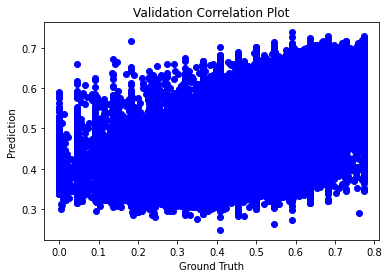

In [34]:
plt.scatter(y_val_from_train,y_predict_val_from_train,c="blue")
plt.xlabel("Ground Truth")
plt.ylabel("Prediction")
plt.title("Validation Correlation Plot")
plt.show()

#Predicting Test

In [35]:
X_list_test = np.load('test_allX.npy')
# X_list_test_c = np.load('./gdrive/MyDrive/ColabDrive/test_allX_c.npy')
# X_list_test_m = np.concatenate([X_list_test,X_list_test_c], axis = -2)
# X_list_test.shape, X_list_test_c.shape, X_list_test_m.shape

In [36]:
Y_predict_list_test = model.predict(X_list_test[:,:,:])
Y_predict_list_test.shape

(71103, 1)

In [37]:
test_raw[1] = Y_predict_list_test
test_raw.head()

,0,1
0,TGCATTTTTTTCACATCAAAAAAAAAAAAAAAAAAAAAAACTAGCA...,0.517249
1,TGCATTTTTTTCACATCAAAAAAAAAAAAAAAAAAAGAAAACGAGC...,0.507149
2,TGCATTTTTTTCACATCAAAAAAAAAAAAAAAAAAAGAAAACGAGC...,0.490074
3,TGCATTTTTTTCACATCAAAAAAAAAAAAAAAAAAAGAAAACGAGC...,0.477438
4,TGCATTTTTTTCACATCAAAAAAAAAAAAAAAAAAAGAAAACGAGC...,0.526502


In [38]:
test_raw.to_csv('test_sequences_simon_22.txt', sep='\t', header=False, index=False)

In [39]:
test_raw_simon = pd.read_csv('test_sequences_simon_22.txt', delimiter = '\t', header=None)
test_raw_simon.head()

,0,1
0,TGCATTTTTTTCACATCAAAAAAAAAAAAAAAAAAAAAAACTAGCA...,0.517249
1,TGCATTTTTTTCACATCAAAAAAAAAAAAAAAAAAAGAAAACGAGC...,0.507149
2,TGCATTTTTTTCACATCAAAAAAAAAAAAAAAAAAAGAAAACGAGC...,0.490074
3,TGCATTTTTTTCACATCAAAAAAAAAAAAAAAAAAAGAAAACGAGC...,0.477438
4,TGCATTTTTTTCACATCAAAAAAAAAAAAAAAAAAAGAAAACGAGC...,0.526502


In [40]:
import json
from collections import OrderedDict
# file available at
#https://github.com/de-Boer-Lab/DREAM-2022/blob/main/sample_submission.json
with open('sample_submission.json', 'r') as f:
  ground = json.load(f)
indices = np.array([int(indice) for indice in list(ground.keys())])
PRED_DATA = OrderedDict()
for i in indices:
#Y_pred is an numpy array of dimension (71103,) that contains your
#predictions on the test sequences
  PRED_DATA[str(i)] = float(Y_predict_list_test[i])
def dump_predictions(prediction_dict, prediction_file):
  with open(prediction_file, 'w') as f:
    json.dump(prediction_dict, f)
dump_predictions(PRED_DATA, 'pred_tsaiminChen0730.json')